In [1]:
from skfem import *
from skfem.models.poisson import laplace, mass
from skfem.io import from_meshio

import numpy as np
import matplotlib.pyplot as plt


In [2]:
radii = [1.0, 2.0]
lcar = 0.1

mesh = MeshTri.init_tensor(
    np.linspace(*radii, 1 + int(np.diff(radii) / lcar)),
    np.linspace(0, np.pi / 2, 1 + int(3 * np.pi / 4 / lcar)),
).with_boundaries(
    {
        "ground": lambda xi: xi[1] == 0.0,
        "positive": lambda xi: xi[1] == np.pi / 2,
    }
)
mesh = mesh.translated(
    mesh.p[0] * np.stack([np.cos(mesh.p[1]), np.sin(mesh.p[1])]) - mesh.p
)

elements = ElementTriP2()
basis = Basis(mesh, elements)
A = asm(laplace, basis)

u = basis.zeros()
u[basis.get_dofs("positive")] = 1.0
u = solve(*condense(A, x=u, D=basis.get_dofs({"positive", "ground"})))

M = asm(mass, basis)
u_exact = 2 * np.arctan2(*basis.doflocs[::-1]) / np.pi
u_error = u - u_exact
error_L2 = np.sqrt(u_error @ M @ u_error)
conductance = {"skfem": u @ A @ u, "exact": 2 * np.log(2) / np.pi}


@Functional
def port_flux(w):
    from skfem.helpers import dot, grad

    return dot(w.n, grad(w["u"]))


current = {}
for port, boundary in mesh.boundaries.items():
    fbasis = FacetBasis(mesh, elements, facets=boundary)
    current[port] = asm(port_flux, fbasis, u=u)

print("L2 error:", error_L2)
print("conductance:", conductance)
print("Current in through ports:", current)
 

L2 error: 1.8559911793187872e-07
conductance: {'skfem': 0.4412715317140697, 'exact': 0.4412712003053032}
Current in through ports: {'left': 0.0016267154904603736, 'bottom': -0.4414157567756581, 'right': -0.000875923725634101, 'top': 0.44141575677565065, 'ground': -0.4414157567756581, 'positive': 0.44141575677565065}


/var/folders/tv/5t3f3sm57dq1rdrd6cnz0j8h0000gp/T/ipykernel_99650/657509644.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  np.linspace(*radii, 1 + int(np.diff(radii) / lcar)),


In [3]:
help(mesh.p)

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any object that can

In [4]:
mesh.p

array([[1.00000000e+00, 9.97668769e-01, 9.90685946e-01, 9.79084088e-01,
        9.62917287e-01, 9.42260922e-01, 9.17211302e-01, 8.87885218e-01,
        8.54419405e-01, 8.16969893e-01, 7.75711291e-01, 7.30835964e-01,
        6.82553143e-01, 6.31087944e-01, 5.76680322e-01, 5.19583950e-01,
        4.60065038e-01, 3.98401090e-01, 3.34879612e-01, 2.69796771e-01,
        2.03456013e-01, 1.36166649e-01, 6.82424134e-02, 1.11022302e-16,
        1.10000000e+00, 1.09743565e+00, 1.08975454e+00, 1.07699250e+00,
        1.05920902e+00, 1.03648701e+00, 1.00893243e+00, 9.76673740e-01,
        9.39861345e-01, 8.98666882e-01, 8.53282420e-01, 8.03919561e-01,
        7.50808458e-01, 6.94196739e-01, 6.34348354e-01, 5.71542345e-01,
        5.06071542e-01, 4.38241199e-01, 3.68367573e-01, 2.96776448e-01,
        2.23801614e-01, 1.49783314e-01, 7.50666547e-02, 0.00000000e+00,
        1.20000000e+00, 1.19720252e+00, 1.18882314e+00, 1.17490091e+00,
        1.15550074e+00, 1.13071311e+00, 1.10065356e+00, 1.065462

In [5]:
mesh.p.shape

(2, 264)

<skfem MeshTri1 object>
  Number of elements: 460
  Number of vertices: 264
  Number of nodes: 264
  Named boundaries [# facets]: left [23], bottom [10], right [23], top [10], ground [10], positive [10]


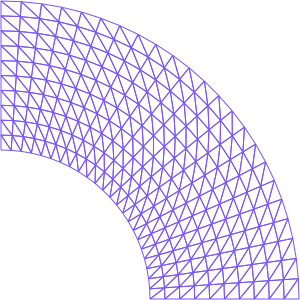

In [6]:
print(mesh)
mesh

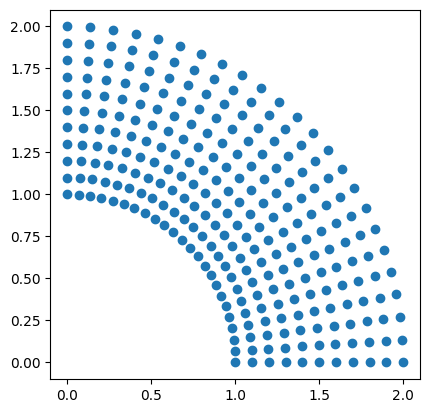

In [7]:
fig, ax = plt.subplots()
ax.scatter(x=mesh.p[0], y=mesh.p[1])
ax.set_aspect('equal', 'box')

In [8]:
help(condense)

Help on function condense in module skfem.utils:

condense(A: scipy.sparse._matrix.spmatrix, b: Union[numpy.ndarray, scipy.sparse._matrix.spmatrix, NoneType] = None, x: Optional[numpy.ndarray] = None, I: Union[numpy.ndarray, skfem.assembly.dofs.DofsView, Dict[str, skfem.assembly.dofs.DofsView], NoneType] = None, D: Union[numpy.ndarray, skfem.assembly.dofs.DofsView, Dict[str, skfem.assembly.dofs.DofsView], NoneType] = None, expand: bool = True) -> Union[scipy.sparse._matrix.spmatrix, Tuple[scipy.sparse._matrix.spmatrix, numpy.ndarray], Tuple[scipy.sparse._matrix.spmatrix, scipy.sparse._matrix.spmatrix], Tuple[scipy.sparse._matrix.spmatrix, numpy.ndarray, numpy.ndarray], Tuple[scipy.sparse._matrix.spmatrix, numpy.ndarray, numpy.ndarray, numpy.ndarray], Tuple[scipy.sparse._matrix.spmatrix, scipy.sparse._matrix.spmatrix, numpy.ndarray, numpy.ndarray]]
    Eliminate degrees-of-freedom from a linear system.

    The user should provide the linear system ``A`` and ``b``
    and either the set

In [9]:
u

array([0.        , 0.04347826, 0.08695652, 0.13043478, 0.17391304,
       0.2173913 , 0.26086957, 0.30434783, 0.34782609, 0.39130435,
       0.43478261, 0.47826087, 0.52173913, 0.56521739, 0.60869565,
       0.65217391, 0.69565217, 0.73913043, 0.7826087 , 0.82608696,
       0.86956522, 0.91304348, 0.95652174, 1.        , 0.        ,
       0.04347826, 0.08695652, 0.13043478, 0.17391304, 0.2173913 ,
       0.26086957, 0.30434783, 0.34782609, 0.39130435, 0.43478261,
       0.47826087, 0.52173913, 0.56521739, 0.60869565, 0.65217391,
       0.69565217, 0.73913043, 0.7826087 , 0.82608696, 0.86956522,
       0.91304348, 0.95652174, 1.        , 0.        , 0.04347826,
       0.08695652, 0.13043478, 0.17391304, 0.2173913 , 0.26086957,
       0.30434783, 0.34782609, 0.39130435, 0.43478261, 0.47826087,
       0.52173913, 0.56521739, 0.60869565, 0.65217391, 0.69565217,
       0.73913043, 0.7826087 , 0.82608696, 0.86956522, 0.91304348,
       0.95652174, 1.        , 0.        , 0.04347826, 0.08695

In [10]:
type(u)

numpy.ndarray

In [11]:
basis

<skfem CellBasis(MeshTri1, ElementTriP2) object>
  Number of elements: 460
  Number of DOFs: 987
  Size: 397440 B

In [12]:
help(basis)

Help on CellBasis in module skfem.assembly.basis.cell_basis object:

class CellBasis(skfem.assembly.basis.abstract_basis.AbstractBasis)
 |  CellBasis(mesh: skfem.mesh.mesh.Mesh, elem: skfem.element.element.Element, mapping: Optional[skfem.mapping.mapping.Mapping] = None, intorder: Optional[int] = None, elements: Optional[Any] = None, quadrature: Optional[Tuple[numpy.ndarray, numpy.ndarray]] = None, dofs: Optional[skfem.assembly.dofs.Dofs] = None)
 |
 |  For fields defined inside the domain.
 |
 |  :class:`~skfem.assembly.CellBasis` object is a combination of
 |  :class:`~skfem.mesh.Mesh` and :class:`~skfem.element.Element`.
 |
 |  >>> from skfem import *
 |  >>> m = MeshTri.init_symmetric()
 |  >>> e = ElementTriP1()
 |  >>> basis = CellBasis(m, e)
 |
 |  The resulting objects are used in the assembly.
 |
 |  >>> from skfem.models.poisson import laplace
 |  >>> K = asm(laplace, basis)
 |  >>> K.shape
 |  (5, 5)
 |
 |  Method resolution order:
 |      CellBasis
 |      skfem.assembly.ba

In [13]:
mass

In [14]:
help(mass)

Help on BilinearForm in module skfem.assembly.form.bilinear_form object:

class BilinearForm(skfem.assembly.form.form.Form)
 |  BilinearForm(form: Union[Callable, ForwardRef('Form'), NoneType] = None, dtype: Union[Type[numpy.float64], Type[numpy.complex64]] = <class 'numpy.float64'>, nthreads: int = 0, **params)
 |
 |  A bilinear form for finite element assembly.
 |
 |  Bilinear forms are defined using functions that takes three arguments:
 |  trial function ``u``, test function ``v``, and a dictionary of additional
 |  parameters ``w``.
 |
 |  >>> from skfem import BilinearForm, Basis, MeshTri, ElementTriP1
 |  >>> form = BilinearForm(lambda u, v, _: u * v)
 |  >>> form.assemble(Basis(MeshTri(), ElementTriP1())).toarray()
 |  array([[0.08333333, 0.04166667, 0.04166667, 0.        ],
 |         [0.04166667, 0.16666667, 0.08333333, 0.04166667],
 |         [0.04166667, 0.08333333, 0.16666667, 0.04166667],
 |         [0.        , 0.04166667, 0.04166667, 0.08333333]])
 |
 |  Alternatively, 